In [221]:
import numpy as np
import scipy as sp


def rk4(f, h, t, y, *args):
    h2 = h*0.5
    k1 = f(t, y, *args)
    k2 = f(t+h2, y+h2*k1, *args)
    k3 = f(t+h2, y+h2*k2, *args)
    k4 = f(t+h, y+h*k3, *args)
    return y + h*(k1 + 2.0*(k2+k3) + k4)/6.0

def care(A, B, Q, R):
    X = sp.linalg.solve_continuous_are(A, B, Q, R)
    K = np.linalg.solve(R, B.T@X)
    return K
    
def lqr(A, B, Q, R):
    return care(A, B, Q, R)

def lqe(A, C, Vd, Vn):
    return care(A.T, C.T, Vd, Vn).T


g = 10.0
l = 2.0
m = 1.0
M = 5.0
d = 1.0

A = np.array([[0.0,    1.0,         0.0, 0.0],
              [0.0,   -d/M,       m*g/M, 0.0],
              [0.0,    0.0,         0.0, 1.0],
              [0.0, -d/M/l, (m+M)*g/M/l, 0.0]])

B = np.array([[0.0], [1.0/M], [0.0], [1.0/M/l]])
Q = np.eye(4)
R = 0.000001*np.eye(1)
K = lqr(A, B, Q, R)

C = np.array([[1.0, 0.0, 0.0, 0.0]])
Vd = 0.04*np.eye(4)
Vn = 0.0002*np.eye(1)
Kf = lqe(A, C, Vd, Vn)


def f(t, x, u, dd):
    sinQ = np.sin(x[2])
    cosQ = np.cos(x[2])
    ddx = (m*g*sinQ*cosQ - m*l*x[3]*x[3]*sinQ - d*x[1] + u[0])/(M + m - m*cosQ*cosQ)
    ddQ = (ddx*cosQ + g*sinQ)/l
    return np.array([x[1], ddx, x[3], ddQ]) + dd

def kf(t, x, u, ym):
    return (A - Kf@C)@x + Kf@ym + B@u

ref = np.array([1.0, 0.0, 0.0, 0.0])
y0 = np.array([-1.0, 0.0, 0.1, 0.0])

ys = [y0]
yfs = [y0]
us = []
yms = []

T = 10
dt = 0.001
ts = [0.0]

while ts[-1] < T:
    u = K@(ref - yfs[-1])
    vd = np.sqrt(Vd)@np.random.normal(scale=1, size=(4,))
    y = rk4(f, dt, ts[-1], ys[-1], u, vd)

    vn = (np.sqrt(Vn)*np.random.normal(scale=1))[0]
    ym = C@ys[-1] + vn
    yf = rk4(kf, dt, ts[-1], yfs[-1], u, ym)
    
    us.append(u[0])
    ys.append(y)
    yms.append(ym)
    yfs.append(yf)
    ts.append(ts[-1]+dt)

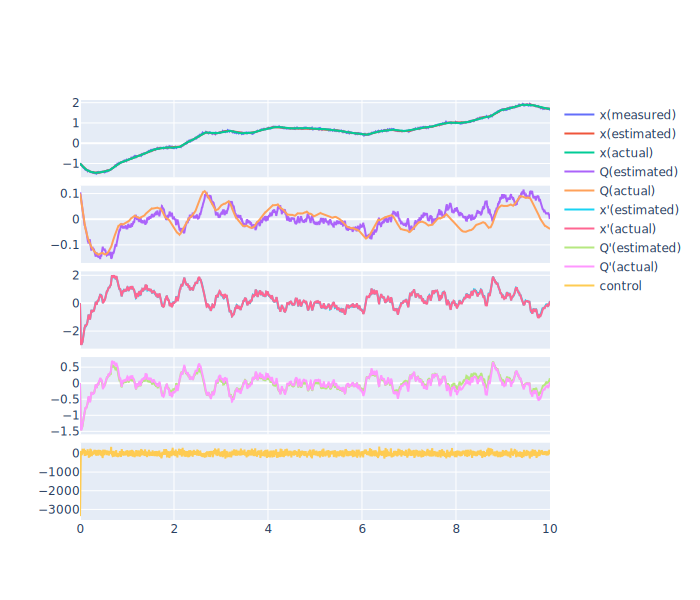

In [222]:
import plotly.graph_objects as go


t = np.hstack(ts)
y = np.vstack(ys).T
ym = np.vstack(yms)[:,0]
yf = np.vstack(yfs).T
yd = np.vstack(ys).T - np.vstack(yfs).T


fig = go.Figure().set_subplots(rows=5, cols=1, shared_xaxes=True, vertical_spacing=0.02)

fig.add_trace(go.Scatter(x=t, y=ym, name="x(measured)"), row=1, col=1)
fig.add_trace(go.Scatter(x=t, y=yf[0], name="x(estimated)"), row=1, col=1)
fig.add_trace(go.Scatter(x=t, y=y[0], name="x(actual)"), row=1, col=1)

fig.add_trace(go.Scatter(x=t, y=yf[2], name="Q(estimated)"), row=2, col=1)
fig.add_trace(go.Scatter(x=t, y=y[2], name="Q(actual)"), row=2, col=1)

fig.add_trace(go.Scatter(x=t, y=yf[1], name="x'(estimated)"), row=3, col=1)
fig.add_trace(go.Scatter(x=t, y=y[1], name="x'(actual)"), row=3, col=1)

fig.add_trace(go.Scatter(x=t, y=yf[3], name="Q'(estimated)"), row=4, col=1)
fig.add_trace(go.Scatter(x=t, y=y[3], name="Q'(actual)"), row=4, col=1)

fig.add_trace(go.Scatter(x=t, y=us, name="control"), row=5, col=1)

fig.update_layout(height=600)
fig.show("svg")

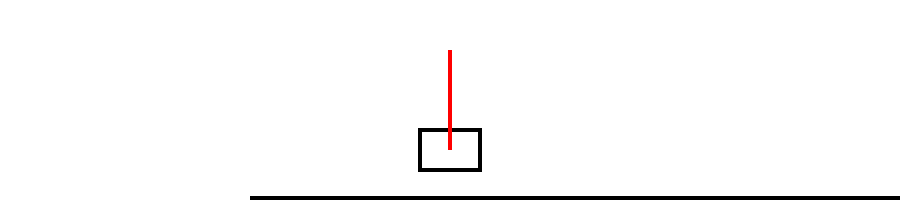

In [223]:
from IPython.display import SVG

scale = 50

SVG(f"""<svg width="900" height="200" viewBox="-200 -150 400 200">
<g stroke-width="4">
<animateTransform attributeName="transform"
                          type="translate"
                          values="{";".join((y[0]*scale).astype(str))}"
                          dur="{T}s"
                          repeatCount="indefinite"/>
<rect x="-30" y="-20" width="60" height="40" fill="transparent" stroke="black" >
</rect>
<line x1="0" x2="0" y1="0" y2="{-l*scale}" stroke="red">
<animateTransform attributeName="transform"
                          type="rotate"
                          values="{";".join((-np.degrees(y[2])).astype(str))}"
                          dur="{T}s"
                          repeatCount="indefinite"/>
</line>
</g>
<rect x="-200" y="46" width="100%" height="4"/>
<rect x="-200" y="46" width="0%" height="4" fill="red"><animate 
                     attributeName="width" 
                     from="0%" 
                     to="100%"
                     dur="{T}s"
                     repeatCount="indefinite"/></rect>
</svg>""")

In [232]:
from scipy.optimize import minimize

def solve(L, F, G, boundary, elements, guess):
    (X0,t0), (Xf,tf) = boundary
    if tf is None:
        tt = lambda x: x[-1]-t0
    else:
        tt = lambda x, dt=tf-t0: dt

    def diff_constraints(x, compute=[make_diff_constraints(F, el, tt) for el in elements]):
        Cs = [dc(x) for dc in compute]
        r = []
        for c, x0 in zip(Cs[0][0], X0):
            if x0 is not None:
                r.append(c+x0)
        for c, xf in zip(Cs[-1][-1], Xf):
            if xf is not None:
                r.append(c-xf)
        for cs in Cs:
            r += cs[1:-1].reshape(-1).tolist()
        for csA,csB in zip(Cs, Cs[1:]):
            r += (csA[-1]+csB[0]).tolist()      
        return np.array(r)
    
    def trans_constraints(x, compute=[eval_function(G, el, np.linspace(-1, 1, len(el.f))) for el in elements]):
        return np.hstack([G(x) for G in compute]).reshape(-1)

    cs = [{'type': 'eq', 'fun': diff_constraints}, {'type': 'ineq', 'fun': trans_constraints}] 

    cost_bits = [(integrate_function(L, el, len(el.f)+1) if callable(L) else lambda x: 2.0*L, el.dt) for el in elements]    
    def cost(x):
        t = tt(x)
        return sum(0.5*dt*t*cost_bit(x) for cost_bit, dt in cost_bits)
    
    return minimize(cost, method='SLSQP', x0=guess, constraints=cs, jac='2-point', options={'maxiter':2000})


F = lambda X,U: f(0, X, U, np.zeros(X.shape))
L = lambda X,U: U[0]*U[0]+1
state_len = 4
control_len = 1
X0 = (0, 0, np.pi, 0)
XF = (0, 0, 0, 0)
Nel = 30

guess = np.append(np.linspace((0, 0, np.pi, 0, 0), (0, 0, 0, 0, 0), num=2*Nel+1).swapaxes(0,1).reshape(-1), 2)

def diff_constraints(state):
    tf = state[-1]
    y = state[:-1].reshape((-1,state_len+control_len)).T
    xs = y[:state_len,:]
    us = y[state_len:,:]
    f = F(xs, us)
    r = xs[:,0]-X0
    mid = (tf/Nel/8)*(f[:,0:-2:2]-f[:,2::2])+0.5*(xs[:,0:-2:2]+xs[:,2::2]) - xs[:,1:-1:2]
    r = np.append(r, mid.T.reshape(-1))
    ends = (tf/Nel/6)*(f[:,0:-2:2]+4*f[:,1:-1:2]+f[:,2::2]) + xs[:,0:-2:2] - xs[:,2::2]
    r = np.append(r, ends.T.reshape(-1))
    r = np.append(r, xs[:,-1]-XF)
    return r
    
def cost(state):
    tf = state[-1]
    y = state[:-1].reshape((-1,state_len+control_len)).T
    xs = y[:state_len,:]
    us = y[state_len:,:]
    c = L(xs, us).reshape(-1)
    return (tf/Nel/6)*np.sum(c[0:-2:2]+4*c[1:-1:2]+c[2::2])

r = minimize(cost, method='SLSQP', x0=guess, constraints=[{'type': 'eq', 'fun': diff_constraints}], jac='2-point', options={'maxiter':2000})
print(r)

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 1892.5058231318326
       x: [ 0.000e+00  0.000e+00 ...  7.136e-01  5.803e+00]
     nit: 426
     jac: [ 0.000e+00  0.000e+00 ...  4.601e-02  3.261e+02]
    nfev: 130937
    njev: 426


In [233]:
def hermite_spline2(x, tf):
    Nel = len(x)//2
    a = x[:-2:2]
    b = -Nel*(3*x[:-2:2] + x[2::2] - 4*x[1:-1:2])/tf
    c = 2*Nel*Nel*(x[:-2:2] + x[2::2] - 2*x[1:-1:2])/tf/tf
    return sp.interpolate.PPoly(np.array([c,b,a]), np.linspace(0, tf, Nel+1))

def hermite_spline3(x, f, tf):
    Nel = len(x)//2
    a = x[:-2:2]
    b = f[:-2:2]
    c = -0.5*Nel*(3*f[:-2:2] + f[2::2] - 4*f[1:-1:2])/tf
    d = 2*Nel*Nel*(f[:-2:2] + f[2::2] - 2*f[1:-1:2])/tf/tf/3
    return sp.interpolate.PPoly(np.array([d,c,b,a]), np.linspace(0, tf, Nel+1))

tf = r.x[-1]
y = r.x[:-1].reshape((-1,state_len+control_len))
xs = y[:,:state_len]
us = y[:,state_len:]
ts = np.linspace(0,tf,Nel+1)
U = hermite_spline2(us.reshape(-1), tf)
tss = [0]
yss = [np.array([0,0,np.pi,0])]
uss = []
while tss[-1] < tf:
    u = U(tss[-1])
    vd = np.sqrt(Vd)@np.random.normal(scale=0, size=(4,))
    y = rk4(f, dt, ts[-1], yss[-1], [u], vd)
    
    uss.append(u)
    yss.append(y)
    tss.append(tss[-1]+dt)

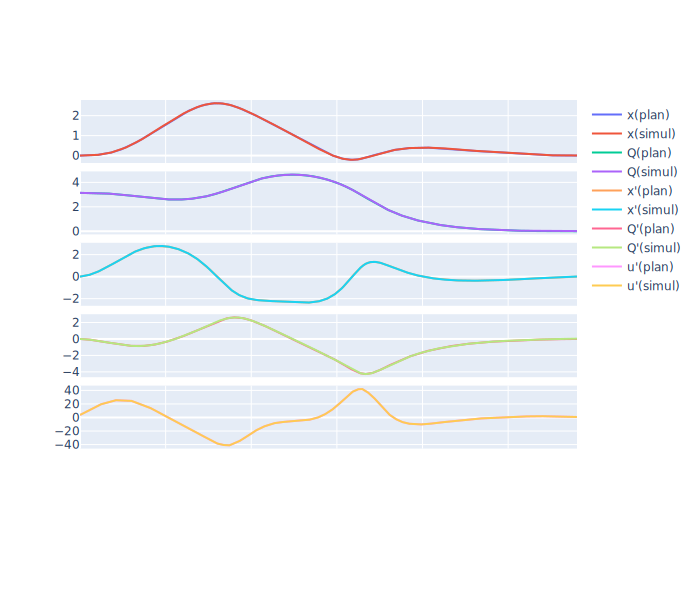

In [236]:
yss2 = np.vstack(yss).T

fs = F(xs.T, us.T)

X = hermite_spline3(xs[:,0].reshape(-1), fs[0,:].reshape(-1), tf)
Q = hermite_spline3(xs[:,2].reshape(-1), fs[2,:].reshape(-1), tf)
dX = hermite_spline3(xs[:,1].reshape(-1), fs[1,:].reshape(-1), tf)
dQ = hermite_spline3(xs[:,3].reshape(-1), fs[3,:].reshape(-1), tf)

fig = go.Figure().set_subplots(rows=6, cols=1, shared_xaxes=True, vertical_spacing=0.02)
fig.add_scatter(x=tss, y=X(tss), name='x(plan)', col=1, row=1)
fig.add_scatter(x=tss, y=yss2[0], name='x(simul)', col=1, row=1)
fig.add_scatter(x=tss, y=Q(tss), name='Q(plan)', col=1, row=2)
fig.add_scatter(x=tss, y=yss2[2], name='Q(simul)', col=1, row=2)
fig.add_scatter(x=tss, y=dX(tss), name='x\'(plan)', col=1, row=3)
fig.add_scatter(x=tss, y=yss2[1], name='x\'(simul)', col=1, row=3)
fig.add_scatter(x=tss, y=dQ(tss), name='Q\'(plan)', col=1, row=4)
fig.add_scatter(x=tss, y=yss2[3], name='Q\'(simul)', col=1, row=4)
fig.add_scatter(x=tss, y=U(tss), name='u\'(plan)', col=1, row=5)
fig.add_scatter(x=tss, y=uss, name='u\'(simul)', col=1, row=5)
fig.update_layout(height=600)
fig.show()

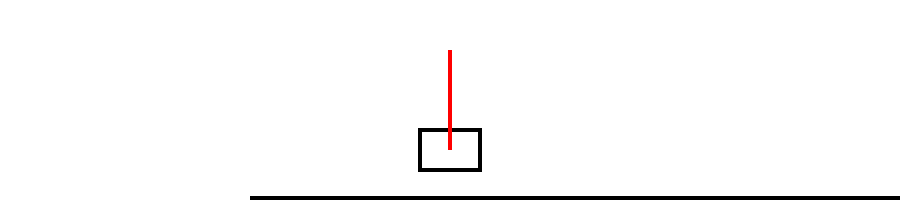

In [235]:
from IPython.display import SVG

scale = 50

SVG(f"""<svg width="900" height="200" viewBox="-200 -150 400 200">
<g stroke-width="4">
<animateTransform attributeName="transform"
                          type="translate"
                          values="{";".join((yss2[0]*scale).astype(str))}"
                          dur="{tf}s"
                          repeatCount="indefinite"/>
<rect x="-30" y="-20" width="60" height="40" fill="transparent" stroke="black" >
</rect>
<line x1="0" x2="0" y1="0" y2="{-l*scale}" stroke="red">
<animateTransform attributeName="transform"
                          type="rotate"
                          values="{";".join((-np.degrees(yss2[2])).astype(str))}"
                          dur="{tf}s"
                          repeatCount="indefinite"/>
</line>
</g>
<rect x="-200" y="46" width="100%" height="4"/>
<rect x="-200" y="46" width="0%" height="4" fill="red"><animate 
                     attributeName="width" 
                     from="0%" 
                     to="100%"
                     dur="{tf}s"
                     repeatCount="indefinite"/></rect>
</svg>""")